# Protein Folding Principles Dataset

In [1]:
import matplotlib.pyplot as plt

In [2]:
#Change root directory to the project root
#This is necessary to import modules from the project
#without having to install them

import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
## Interactive reloading
#This is useful for Jupyter notebooks to automatically reload modules

%load_ext autoreload
%autoreload 2

## Get PDB codes for high quality structures using PISCES

In [4]:
from dataset.pisces import fetch_pisces_table, get_filtered_pdb_codes

# Fetch and filter
pisces_df = fetch_pisces_table()
pdb_ids = get_filtered_pdb_codes(pisces_df)

# Preview results
print(f"Found {len(pdb_ids)} high-quality structures with pdb codes.")
print(pdb_ids[:10])


Detected PISCES columns: ['PDBchain', 'len', 'method', 'resol', 'rfac', 'freerfac']
Found 11116 high-quality structures with pdb codes.
['5D8V', '5NW3', '1UCS', '3X2M', '2VB1', '1US0', '6E6O', '6S2M', '1R6J', '4REK']


## Find beta-beta patterns and their chirality in PDB entries

In [5]:
from dataset.io_utils import fetch_mmcif_file, run_dssp_on_mmcif
from dataset.motif_logic import (
    detect_hairpins,
    assign_beta_chirality_strand_axis,
    assign_beta_chirality_local,
)
import pandas as pd
import os
from tqdm import tqdm 

results_strandaxis = []
results_local = []

for pdb_id in tqdm(pdb_ids, desc="Processing PDBs"):
    pdb_path = fetch_mmcif_file(pdb_id, outdir="./pdb_files")
    try:
        model, dssp_df = run_dssp_on_mmcif(
            pdb_path,
            dssp_exe="/opt/anaconda3/envs/folding-dssp/bin/mkdssp",
        )
        if dssp_df is None:
            print(f"DSSP failed for {pdb_id}. Skipping.")
            continue

        hairpin_annotations = detect_hairpins(dssp_df)

        # Strand-axis method
        df_strandaxis = assign_beta_chirality_strand_axis(
            model, dssp_df, hairpin_annotations
        )
        results_strandaxis.append(df_strandaxis)

        # Local backbone method
        df_local = assign_beta_chirality_local(
            model, dssp_df, hairpin_annotations
        )
        results_local.append(df_local)

    except Exception as e:
        print(f"Error processing {pdb_id}: {e}")
        continue
    finally:
        pass
        # if os.path.exists(pdb_path):
        #     os.remove(pdb_path)

all_hairpins_strandaxis = pd.concat(results_strandaxis, ignore_index=True)
all_hairpins_local = pd.concat(results_local, ignore_index=True)

all_hairpins_local.head(10)


Processing PDBs:   6%|▌         | 689/11116 [04:06<56:30,  3.08it/s]  /opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 2yln: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:   6%|▌         | 690/11116 [04:06<49:38,  3.50it/s]

DSSP failed for 2YLN. Skipping.


Processing PDBs:  31%|███▏      | 3481/11116 [22:32<37:23,  3.40it/s]  /opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 2ibn: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  31%|███▏      | 3482/11116 [22:33<34:12,  3.72it/s]

DSSP failed for 2IBN. Skipping.


Processing PDBs:  33%|███▎      | 3713/11116 [24:01<37:16,  3.31it/s]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 3tos: Structure/DSSP mismatch at <Residue SAH het=H_SAH resseq=258 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  33%|███▎      | 3714/11116 [24:03<1:41:16,  1.22it/s]

DSSP failed for 3TOS. Skipping.


Processing PDBs:  43%|████▎     | 4822/11116 [32:43<44:00,  2.38it/s]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 3zeu: Structure/DSSP mismatch at <Residue MET het=  resseq=194 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  43%|████▎     | 4823/11116 [32:44<50:46,  2.07it/s]

DSSP failed for 3ZEU. Skipping.


Processing PDBs:  46%|████▋     | 5162/11116 [35:56<37:22,  2.66it/s]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 6dwd: Structure/DSSP mismatch at <Residue NA het=H_NA resseq=712 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  46%|████▋     | 5163/11116 [35:57<56:14,  1.76it/s]

DSSP failed for 6DWD. Skipping.


Processing PDBs:  56%|█████▌    | 6205/11116 [57:33<2:27:24,  1.80s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5le5: Structure/DSSP mismatch at <Residue ARG het=  resseq=3 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  56%|█████▌    | 6206/11116 [57:38<3:59:42,  2.93s/it]

DSSP failed for 5LE5. Skipping.


Processing PDBs:  60%|██████    | 6720/11116 [1:10:41<1:55:40,  1.58s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5b66: Structure/DSSP mismatch at <Residue ALA het=  resseq=11 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  60%|██████    | 6721/11116 [1:10:45<2:51:27,  2.34s/it]

DSSP failed for 5B66. Skipping.


Processing PDBs:  63%|██████▎   | 7013/11116 [1:18:19<1:46:51,  1.56s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 7rf1: Structure/DSSP mismatch at <Residue ALA het=  resseq=11 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  63%|██████▎   | 7014/11116 [1:18:26<3:27:04,  3.03s/it]

DSSP failed for 7RF1. Skipping.


Processing PDBs:  65%|██████▍   | 7207/11116 [1:23:55<1:44:56,  1.61s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5y5s: Structure/DSSP mismatch at <Residue CYS het=  resseq=23 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  65%|██████▍   | 7208/11116 [1:23:59<2:27:08,  2.26s/it]

DSSP failed for 5Y5S. Skipping.


Processing PDBs:  69%|██████▉   | 7715/11116 [1:37:07<1:34:26,  1.67s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 6l8a: Structure/DSSP mismatch at <Residue SO4 het=H_SO4 resseq=504 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  69%|██████▉   | 7716/11116 [1:37:09<1:47:02,  1.89s/it]

DSSP failed for 6L8A. Skipping.


Processing PDBs:  78%|███████▊  | 8684/11116 [2:02:41<1:10:29,  1.74s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 6dhp: Structure/DSSP mismatch at <Residue ALA het=  resseq=11 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  78%|███████▊  | 8685/11116 [2:02:47<2:02:04,  3.01s/it]

DSSP failed for 6DHP. Skipping.


Processing PDBs:  82%|████████▏ | 9112/11116 [2:14:47<1:26:15,  2.58s/it]/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5haz: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  82%|████████▏ | 9113/11116 [2:14:49<1:16:08,  2.28s/it]

DSSP failed for 5HAZ. Skipping.


Processing PDBs:  82%|████████▏ | 9157/11116 [2:15:53<42:50,  1.31s/it]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 4ybb: Structure/DSSP mismatch at <Residue SER het=  resseq=5 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  82%|████████▏ | 9158/11116 [2:16:11<3:25:33,  6.30s/it]

DSSP failed for 4YBB. Skipping.


Processing PDBs:  86%|████████▋ | 9612/11116 [2:29:05<38:51,  1.55s/it]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5x2n: (' ', 951, ' ')
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  86%|████████▋ | 9613/11116 [2:29:09<52:33,  2.10s/it]

DSSP failed for 5X2N. Skipping.


Processing PDBs:  87%|████████▋ | 9694/11116 [2:31:24<38:21,  1.62s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 1vqo: Structure/DSSP mismatch at <Residue ARG het=  resseq=2 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  87%|████████▋ | 9695/11116 [2:31:30<1:10:56,  3.00s/it]

DSSP failed for 1VQO. Skipping.


Processing PDBs:  88%|████████▊ | 9736/11116 [2:32:42<43:59,  1.91s/it]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 3mi0: (' ', 203, ' ')
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  88%|████████▊ | 9737/11116 [2:32:46<59:20,  2.58s/it]

DSSP failed for 3MI0. Skipping.


Processing PDBs:  91%|█████████ | 10127/11116 [2:43:47<27:22,  1.66s/it]/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 5m5e: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  91%|█████████ | 10128/11116 [2:43:48<26:37,  1.62s/it]

DSSP failed for 5M5E. Skipping.


Processing PDBs:  92%|█████████▏| 10174/11116 [2:45:07<32:30,  2.07s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 4y4o: Structure/DSSP mismatch at <Residue VAL het=  resseq=3 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  92%|█████████▏| 10175/11116 [2:45:24<1:44:19,  6.65s/it]

DSSP failed for 4Y4O. Skipping.


Processing PDBs:  94%|█████████▎| 10400/11116 [2:51:35<22:46,  1.91s/it]  /Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 6yn1: Structure/DSSP mismatch at <Residue ARG het=  resseq=35 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  94%|█████████▎| 10401/11116 [2:51:39<27:39,  2.32s/it]

DSSP failed for 6YN1. Skipping.


Processing PDBs:  94%|█████████▍| 10479/11116 [2:53:53<18:40,  1.76s/it]/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/DSSP.py:199: UserWarning: DSSP could not be created due to an error:
bad lexical cast: source type value could not be interpreted as target

  warnings.warn(err)
/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 4w66: DSSP failed to produce an output
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  94%|█████████▍| 10480/11116 [2:53:55<17:38,  1.66s/it]

DSSP failed for 4W66. Skipping.


Processing PDBs:  97%|█████████▋| 10754/11116 [3:01:56<08:43,  1.45s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 4v9f: Structure/DSSP mismatch at <Residue GLY het=  resseq=1 icode= >
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  97%|█████████▋| 10755/11116 [3:02:03<18:15,  3.03s/it]

DSSP failed for 4V9F. Skipping.


Processing PDBs:  97%|█████████▋| 10793/11116 [3:03:11<11:40,  2.17s/it]/Users/shuber/Development/FoldingPrinciplesDataset/dataset/io_utils.py:57: RuntimeWarning: DSSP failed for 3h6i: (' ', 301, ' ')
  warnings.warn(f"DSSP failed for {pdb_id}: {e}", RuntimeWarning)
Processing PDBs:  97%|█████████▋| 10794/11116 [3:03:15<14:25,  2.69s/it]

DSSP failed for 3H6I. Skipping.


Processing PDBs: 100%|██████████| 11116/11116 [3:12:49<00:00,  1.04s/it]


,Chain,strand1_start_idx,strand1_end_idx,strand2_start_idx,strand2_end_idx,strand1_start_res,strand1_end_res,strand2_start_res,strand2_end_res,loop_len,HairpinSequence,LoopSequence,FullChainSequence,PDB,handedness,handedness_magnitude
0,A,45,46,48,54,46,47,49,55,1,CQFMQANVGE,F,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,5d8v,L,-0.340642
1,A,48,54,57,60,49,55,58,61,2,MQANVGEGDWKGC,GD,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,5d8v,L,-0.873705
2,A,67,69,73,74,68,70,74,75,3,LINVNGWC,VNG,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,5d8v,L,-0.978780
3,A,73,74,79,80,74,75,80,81,4,WCASWTLK,ASWT,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,5d8v,L,-0.955260
4,A,2,5,11,13,2,5,11,13,5,KWVCKICGYIYD,KICGY,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,5nw3,L,-0.486571
5,A,11,13,18,19,11,13,18,19,4,IYDEDAGDP,EDAG,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,5nw3,L,-0.996633
6,A,37,38,44,45,37,38,44,45,5,VCPICGAPK,PICGA,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,5nw3,L,-0.372455
7,A,3,6,10,11,4,7,11,12,3,SVVANQLIP,NQL,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,1ucs,R,0.591754
8,A,10,11,15,16,11,12,16,17,3,IPINTAL,INT,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,1ucs,L,-0.992940
9,A,43,44,48,49,44,45,49,50,3,QVNRAVP,NRA,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,1ucs,R,0.066448


In [6]:
# save all_hairpins_local as pandas dataframe
all_hairpins_local.to_csv("all_hairpins_local.csv", index=False)
# save all_hairpins_strandaxis as pandas dataframe
all_hairpins_strandaxis.to_csv("all_hairpins_strandaxis.csv", index=False)


<Axes: xlabel='Loop length', ylabel='Frequency'>

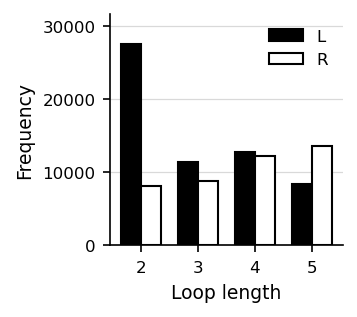

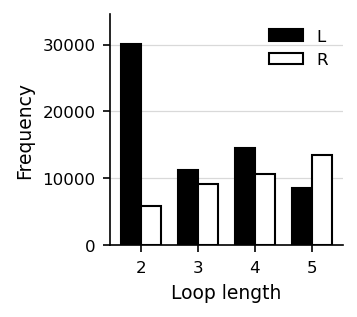

In [7]:
from dataset.plots import plot_loop_length_chirality

plot_loop_length_chirality(all_hairpins_strandaxis)   
plot_loop_length_chirality(all_hairpins_local) 

### What are those R hairpins with length 2?

None of these were observed in the paper. Maybe many of those are quite weak magnitude?

In [10]:
all_hairpins_local[(all_hairpins_local["loop_len"] == 2) & (all_hairpins_local["handedness"] == "R")].head(10)


,Chain,strand1_start_idx,strand1_end_idx,strand2_start_idx,strand2_end_idx,strand1_start_res,strand1_end_res,strand2_start_res,strand2_end_res,loop_len,HairpinSequence,LoopSequence,FullChainSequence,PDB,handedness,handedness_magnitude
35,A,58,59,62,63,67,68,71,72,2,WFKNRT,KN,GYVPAVVIGTGYGAAVSALRLGEAGVQTLMLEMGQLWNQPGPDGNI...,4rek,R,0.007053
39,A,179,181,184,186,188,190,193,195,2,TVFVPNVY,VP,GYVPAVVIGTGYGAAVSALRLGEAGVQTLMLEMGQLWNQPGPDGNI...,4rek,R,0.087194
46,A,431,432,435,436,440,441,444,445,2,FADDFC,DD,GYVPAVVIGTGYGAAVSALRLGEAGVQTLMLEMGQLWNQPGPDGNI...,4rek,R,0.000206
104,A,138,141,144,150,1139,1142,1145,1151,2,VIKTVKSVGMIAG,VK,STPAITLENPDIKYPLRLIDKEVVNHDTRRFRFALPSPEHILGLPV...,5gv8,R,0.138283
155,A,20,24,27,32,45,48,49,54,2,FSVTRGATKGFVT,GA,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,2h5c,R,0.810487
157,A,48,57,60,61,82,91,100,101,2,AVVGTFAARVFPGN,FP,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,2h5c,R,0.063096
161,A,83,86,89,90,120,120,123,124,2,SFVTVRGS,VR,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,2h5c,R,0.684031
242,A,90,91,94,95,128,129,132,133,2,VTISGN,IS,TVIPLQTTVQTPITLGSANNFAVIAGSSVTNTGATNITGDLGLSPG...,6eio,R,0.140925
244,A,100,101,104,108,138,139,142,146,2,TLTPGLYKS,TP,TVIPLQTTVQTPITLGSANNFAVIAGSSVTNTGATNITGDLGLSPG...,6eio,R,0.276572
257,A,90,98,101,102,133,141,144,145,2,WESVFSEFHDADA,DA,MISAAVDRVIGMENAMPWNLPADLAWFKLNKPVIMGRHTWESIGRP...,4pss,R,0.115181


### Plot only strong magnitude examples

<Axes: xlabel='Loop length', ylabel='Frequency'>

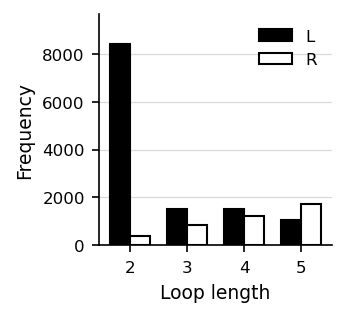

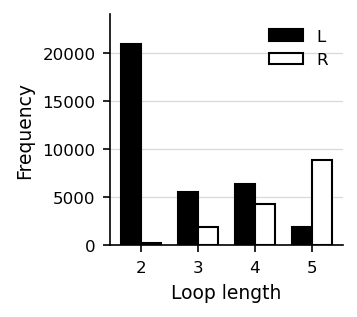

In [12]:
plot_loop_length_chirality(all_hairpins_strandaxis[all_hairpins_strandaxis["handedness_magnitude"].abs() > 0.75])
plot_loop_length_chirality(all_hairpins_local[all_hairpins_local["handedness_magnitude"].abs() > 0.75])

# Writeout all hairpins in a single pdb file

In [ ]:
"""
Write an mmCIF with the first 20 β-hairpins that satisfy

    • loop_len ≤ 5
    • handedness == "L"
    • |handedness_magnitude| > 0.8
    • each flanking β-strand ≥ 5 residues

**Alignment frame (backbone method)**  
    origin      = CA of residue *before* the loop (res_pre = strand1_end)  
    +x (u-axis) = N→C vector of res_pre                              (backbone)  
    +y (v-axis) = CA_pre → CA_post, projected ⟂ u                    (across loop)  
    +z (w-axis) = u × v                                              (right-handed)

Each hairpin is copied into this frame (so all overlay) and stored in its own
chain HP_0001 … HP_0020 in **hairpins_backbone_aligned.cif**.
"""

from copy import deepcopy
import numpy as np
from Bio.PDB import MMCIFParser, MMCIFIO, Structure, Model, Chain, Vector

from dataset.io_utils  import fetch_mmcif_file
from dataset.geometry  import get_ca_from_residue, get_cb_from_residue
from dataset.motif_logic import compute_handedness_from_backbone_geometry   # already imported earlier

# ───────────────────────────── 1 · filter DataFrame
HP_DF = (
    all_hairpins_backbone
      .query(
          "loop_len == 2 and handedness == 'L' "
          "and abs(handedness_magnitude) > 0.8 "
          "and (strand1_end - strand1_start + 1) >= 5 "
          "and (strand2_end - strand2_start + 1) >= 5"
      )
      .head(20)        # keep first 20
      .reset_index(drop=True)
)
print(f"{len(HP_DF)} hairpins selected")

# ───────────────────────────── 2 · Bio.PDB setup
parser    = MMCIFParser(QUIET=True)
structure = Structure.Structure("BACKBONE_ALIGNED")
model0    = Model.Model(0)
structure.add(model0)

def np_vec(v: Vector):
    """Return numpy array from Bio.PDB.Vector"""
    return v.get_array()

# ───────────────────────────── 3 · iterate hairpins
for i, row in HP_DF.iterrows():
    pdb_id, cid = row["PDB"].lower(), row["Chain"]
    s1_start, s1_end = int(row["strand1_start"]), int(row["strand1_end"])
    s2_start, s2_end = int(row["strand2_start"]), int(row["strand2_end"])

    # source structure
    model_src = parser.get_structure(pdb_id, fetch_mmcif_file(pdb_id))[0]
    if cid not in model_src:
        continue
    chain_src = model_src[cid]

    try:
        res_pre  = chain_src[(" ", s1_end,   " ")]  # before loop
        res_post = chain_src[(" ", s2_start, " ")]  # after  loop
    except KeyError:
        continue

    # backbone frame
    ca_pre = np_vec(get_ca_from_residue(res_pre))
    ca_post= np_vec(get_ca_from_residue(res_post))
    if ca_pre is None or ca_post is None:
        continue

    u = np_vec(Vector(res_pre["C"].get_coord()) - Vector(res_pre["N"].get_coord()))
    u /= np.linalg.norm(u)

    v_raw = ca_post - ca_pre
    v_raw -= np.dot(v_raw, u) * u
    v = v_raw / np.linalg.norm(v_raw)

    w = np.cross(u, v)
    R = np.vstack((u, v, w)).T            # local→global; use R.T to rotate coords into frame

    # copy residues, transform
    new_chain = Chain.Chain(f"HP_{i+1:04d}")
    for resseq in range(s1_start, s2_end + 1):
        key = (" ", resseq, " ")
        if key not in chain_src:
            continue
        res = deepcopy(chain_src[key])
        for atom in res.get_atoms():
            xyz = atom.get_vector().get_array() - ca_pre   # translate to origin
            atom.set_coord(R.T @ xyz)                      # rotate into frame
        new_chain.add(res)

    model0.add(new_chain)

# ───────────────────────────── 4 · write mmCIF
out_cif = "hairpins_backbone_aligned.cif"
writer  = MMCIFIO()
writer.set_structure(structure)
writer.save(out_cif)

print(f"✓ saved {len(model0.child_list)} aligned hairpins → {out_cif}")


0 hairpins selected
✓ saved 0 aligned hairpins → hairpins_backbone_aligned.cif


# Other sanity checks

### Check C-b generation function

In [17]:
"""
Generate a minimal Ala residue, compute its Cβ with the library function
`get_cb_from_residue`, and write the four atoms to *test_ala_cb.pdb*.

Run this after you have installed the project (so that
`dataset.geometry.get_cb_from_residue` is importable).
"""

import math
import numpy as np
from pathlib import Path
from Bio.PDB import Atom, Residue, Vector
from dataset.geometry import get_cb_from_residue, CA_CB_BOND

# ───────────────────────────────────────────────────────────────── backbone coords
# realistic peptide geometry (Engh & Huber)
CA = np.array([0.000, 0.000, 0.000])
N  = np.array([1.458, 0.000, 0.000])                      # CA–N  1.458 Å
C  = np.array([
    1.525 * math.cos(math.radians(110.0)),                # CA–C  1.525 Å
    1.525 * math.sin(math.radians(110.0)),
    0.000
])

# ───────────────────────────────────────────────────────────────── build residue
res = Residue.Residue((" ", 1, " "), "ALA", "")
res.add(Atom.Atom("N",  N,  0.0, 0.0, " ", "N",  1))
res.add(Atom.Atom("CA", CA, 0.0, 0.0, " ", "CA", 2))
res.add(Atom.Atom("C",  C,  0.0, 0.0, " ", "C",  3))

# ───────────────────────────────────────────────────────────────── compute Cβ
CB_vec = get_cb_from_residue(res)
assert CB_vec is not None, "get_cb_from_residue returned None"
CB = CB_vec.get_array()

# ───────────────────────────────────────────────────────────────── write PDB
lines = [
    "ATOM      1  N   ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           N\n" % tuple(N),
    "ATOM      2  CA  ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(CA),
    "ATOM      3  C   ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(C),
    "ATOM      4  CB  ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(CB),
    "TER\nEND\n",
]

out = Path("test_ala_cb.pdb")
out.write_text("".join(lines))
print(f"wrote {out.resolve()}")

# ═══════════════════════════════════════════════════════════════════════════════
# optional sanity check
import numpy as np
def angle(a, b, c):
    v1 = a - b
    v2 = c - b
    return math.degrees(
        math.acos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    )

print("CA–CB bond length  :", np.linalg.norm(CB - CA), "Å (expect", CA_CB_BOND, ")")
print("∠N-CA-CB           :", angle(N, CA, CB), "°  (expect ≈109.5°)")
print("∠C-CA-CB           :", angle(C, CA, CB), "°  (expect ≈109.5°)")


wrote /Users/shuber/Development/FoldingPrinciplesDataset/notebooks/test_ala_cb.pdb
CA–CB bond length  : 1.5220000000000002 Å (expect 1.522 )
∠N-CA-CB           : 101.02236461655833 °  (expect ≈109.5°)
∠C-CA-CB           : 101.02236461655835 °  (expect ≈109.5°)


/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element None
  warnings.warn(msg, PDBConstructionWarning)
/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'CA' for Atom (name=CA) with given element None
  warnings.warn(msg, PDBConstructionWarning)
/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element None
  warnings.warn(msg, PDBConstructionWarning)
